In [1]:

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1,'./src')
from grasscare import *
from GDMap import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:

def new_plot_b_array_path(b_array, #data
                labels, #color for each point
                path_length,
                paths_count,
                targets_count,
                video,
                path_names = [],
                title = None, #the title of the graph
                save = False, #save the graph if true
                plot = False, #show the graph if true
                format = 'png', #format of graph: png, pdf, eps
                tail = 0
                ) :

    x = b_array[:,0]
    y = b_array[:,1]
    SMALL_SIZE = 10
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 20

    fig = plt.figure(figsize=(4,4),dpi = 200)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)


    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)

    ax = plt.gca()
    circle2 = plt.Circle((0, 0), 1, color='b', fill=False)
    ax.add_patch(circle2)

    cmap=plt.get_cmap("jet")
    labels_normalized = (labels+1) / (max(labels) + 2)
    colors = ['olivedrab', 'orange']

    for i in range(targets_count):
        if targets_count == 1:
            plt.scatter(x[i],y[i], c = 'b', s = 20, label = 'Target')
        else:
            plt.scatter(x[i],y[i], c = 'b', s = 20, label = 'Target ' + str(i))

    for path_index in range(paths_count):

        index = targets_count + (path_index + 1) * path_length - 1
        plt.scatter(x[index], y[index], c = [colors[path_index]], s = 10)

        start = targets_count + path_index * path_length

        if len(path_names) > 0:
            plt.plot(x[start : index + 1],y[start : index + 1], linewidth=0.5, c = colors[path_index], label = path_names[path_index])
            plt.legend()
        else:
            plt.plot(x[start : index + 1],y[start : index + 1], linewidth=0.5, c = colors[path_index])

    if title:
        plt.title(title)

    plt.savefig('Grasscare.pdf',pad_inches=0, format = 'pdf')

    if plot:
        plt.show()
    plt.close(fig)


    if video:
        filenames = []
        for step in range(path_length):

            name =  'Grasscare: ' + str(step)
            filenames.append(name+'.png')

            fig = plt.figure(figsize=(4,4),dpi = 200)
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)


            plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
            plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
            plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
            plt.rc('figure', titlesize=BIGGER_SIZE)

            ax = plt.gca()
            circle2 = plt.Circle((0, 0), 1, color='b', fill=False)
            ax.add_patch(circle2)

            cmap=plt.get_cmap("jet")
            labels_normalized = labels / max(labels)

            for i in range(targets_count):
                plt.scatter(x[i],y[i], c = 'b', s = 20)

            for path_index in range(paths_count):

                index = step + targets_count + path_index * path_length
                plt.scatter(x[index], y[index], c = [cmap(labels_normalized[path_index])], s = 10)
                if tail == 0:
                    start = step + targets_count + path_index * path_length
                elif tail < step and tail != -1:
                    start = step + targets_count + path_index * path_length - tail
                else:
                    start = targets_count + path_index * path_length

                if len(path_names) > 0:
                    plt.plot(x[start : index + 1],y[start : index + 1], linewidth=0.5, c = cmap(labels_normalized[path_index]), label = path_names[path_index])
                    plt.legend()
                else:
                    plt.plot(x[start : index + 1],y[start : index + 1], linewidth=0.5, c = cmap(labels_normalized[path_index]))


            if title:
                plt.title(name)

            plt.savefig(name, pad_inches=0)
            plt.close(fig)

        gif_plot(filenames, title + '.gif')


    return None



In [3]:

def GROUSE_demo_init(m, r, n_K, missing_percentages):
    U_array, labels, centers = U_array_init(ambient_dimension = m, rank = r, count = 1, clusters = 1)

    print('\n########## GROUSE initialization ##########')
    GROUSE_paths = []
    path_names = []

    labels = np.array([i for i in range(len(missing_percentages))])
    #initializing multiple GROUSE path with same starting point and target but different missing_percentage

    paths_obj = []
    for i in range(len(missing_percentages)):
        path_names.append(str(int(missing_percentages[i] * 100))  + '% missing')

        if i == 0:
            GROUSE_dict = GROUSE_init(U_array, missing_percentage = missing_percentages[i], observed_vectors = n_K)
        else:
            GROUSE_dict = GROUSE_init(U_array, missing_percentage = missing_percentages[i], observed_vectors = n_K,
                                        U_0 = GROUSE_paths[0][0], U_0_load = True)

        GROUSE_paths.append(GROUSE(GROUSE_dict, max_iter = 1, eta = 1))

        print('missing Percentage:', missing_percentages[i])
        print('\tDistance(U*, U_t) = ', d_G(U_array[0], GROUSE_paths[-1][-1]))
        
        obj_array = []
        for p_i in GROUSE_paths[-1]:
            #print(p_i.shape)
            #print(U_array[0].shape)
            obj_array.append(d_G(p_i, U_array[0]))

        paths_obj.append(obj_array)
        plt.plot(obj_array, label = path_names[i])
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('GROUSE training loss')
    plt.legend()
    plt.show()

    optional_params = { 'path_names': path_names, 'Targets': U_array}

    GROUSE_paths = np.array(GROUSE_paths)
    S = []
    for t in range(n_K):
        S.append(GROUSE_paths[:,t])
    S = np.array(S)

    print('S Shape:', S.shape)

    return S, labels, optional_params, paths_obj



In [4]:
#data = np.load('GROUSE_Data.npz')

In [21]:
ambient_dimension = m = 200
rank = r = 5
observed_vectors = n_K = 50
missing_percentages = [0,0.3]



########## GROUSE initialization ##########
missing Percentage: 0
	Distance(U*, U_t) =  1.472415862967415
missing Percentage: 0.3
	Distance(U*, U_t) =  1.8943036880762876


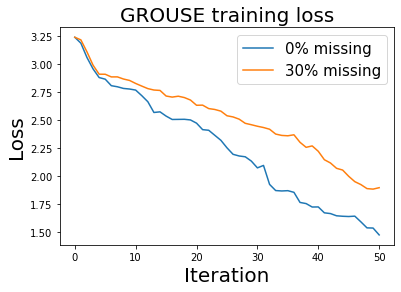

S Shape: (50, 2, 200, 5)


In [33]:
S, labels, optional_params, paths_obj = GROUSE_demo_init(m, r, n_K, missing_percentages)

In [34]:
np.savez_compressed('GROUSE_Data', S = S, labels = labels, optional_params = optional_params, paths_obj = paths_obj, allow_pickle = True)

In [8]:
'''
data = np.load('GROUSE_Data.npz', allow_pickle = True)
S = data['S']
labels = data['labels']

optional_params = data['optional_params'].item()
paths_obj = data['paths_obj']


for i,p in enumerate(paths_obj):
    plt.plot(p, label = optional_params['path_names'][i])

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('GROUSE training loss')
plt.legend()
plt.show()
'''

"\ndata = np.load('GROUSE_Data.npz', allow_pickle = True)\nS = data['S']\nlabels = data['labels']\n\noptional_params = data['optional_params'].item()\npaths_obj = data['paths_obj']\n\n\nfor i,p in enumerate(paths_obj):\n    plt.plot(p, label = optional_params['path_names'][i])\n\nplt.xlabel('Iteration')\nplt.ylabel('Loss')\nplt.title('GROUSE training loss')\nplt.legend()\nplt.show()\n"

In [57]:
tSNE_op = optional_params.copy()

tSNE_op['embedding_method'] = 'EuclideanL2'
tSNE_op['cost_function'] = 't-SNE'

tSNE_embedding, tSNE_info = grasscare_plot(S = S, labels = labels, video = False, optional_params = tSNE_op)



######################### Grasscare 1.1.9 #########################
limit_boundary: False
Multiple Time Frames Mode: On
Reshaped S shape: (101, 200, 5)


KeyboardInterrupt: 


######################### Grasscare 1.1.9 #########################
limit_boundary: True
Multiple Time Frames Mode: On
Reshaped S shape: (101, 200, 5)
Found the optimizer with 499 iterations!                   
Optimum Objective: 8.0969747624663


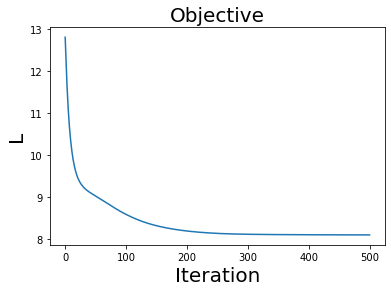

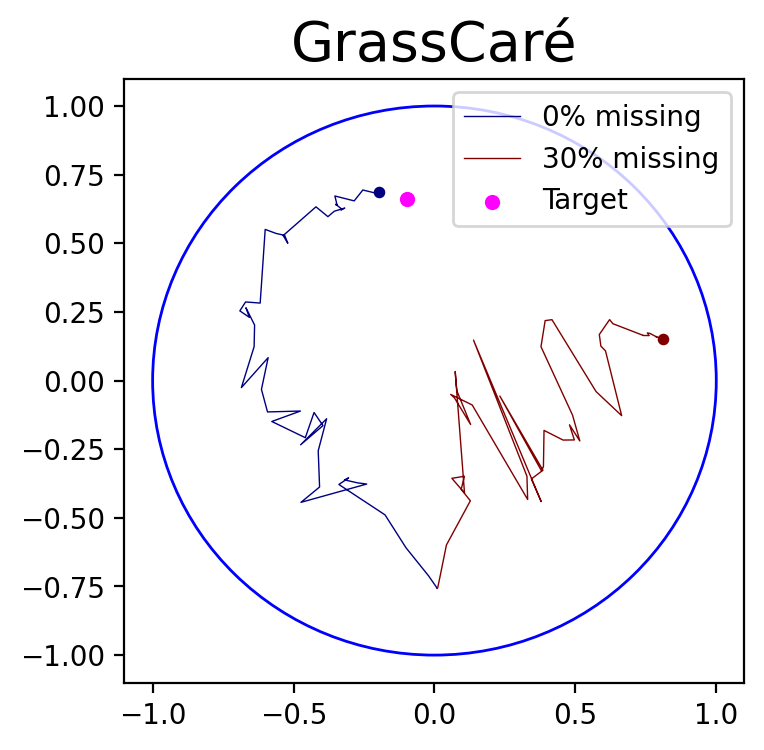

######################### Grasscare END ###########################



In [35]:

#optional_params['video_tail'] = 20
#optional_params['GoogleColab'] = True

embedding, info = grasscare_plot(S = S, labels = labels, video = False, optional_params = optional_params)

#print(embedding)
#print(embedding.shape)


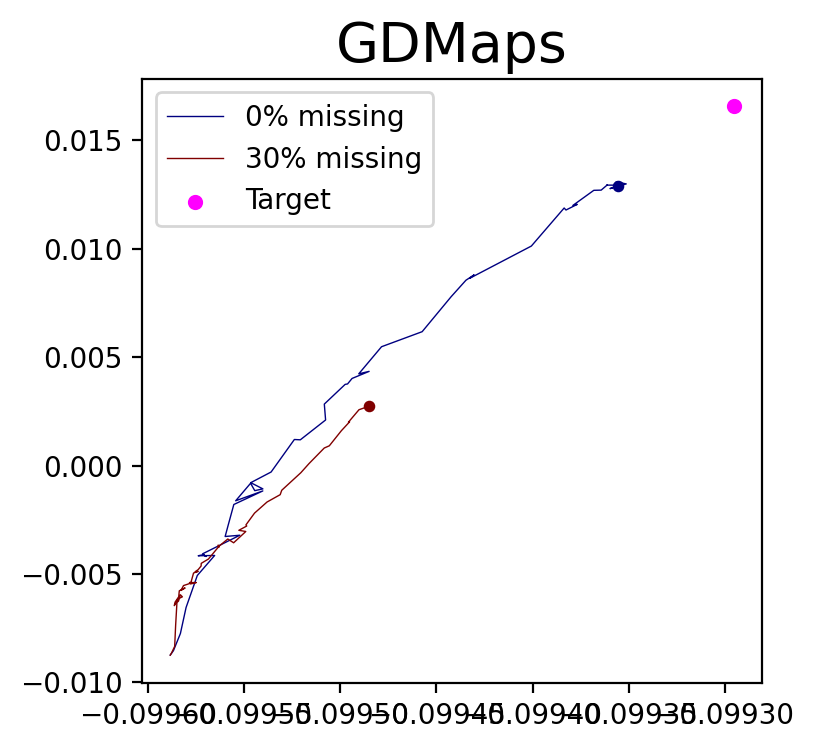

In [56]:
b_array_GDM = GDMap(U_array = merged_U_array, rank = r)


plot_b_array_path(b_array = b_array_GDM,
                            labels = labels,
                            paths_count = S.shape[1],
                            path_length = S.shape[0],
                            targets_count = 1,
                            video = False,
                            title = 'GDMaps',
                            save = True,
                            plot = True,
                            format = 'pdf',
                            tail = -1,
                            path_names = optional_params['path_names'],
                            limit_boundary = False
                            )

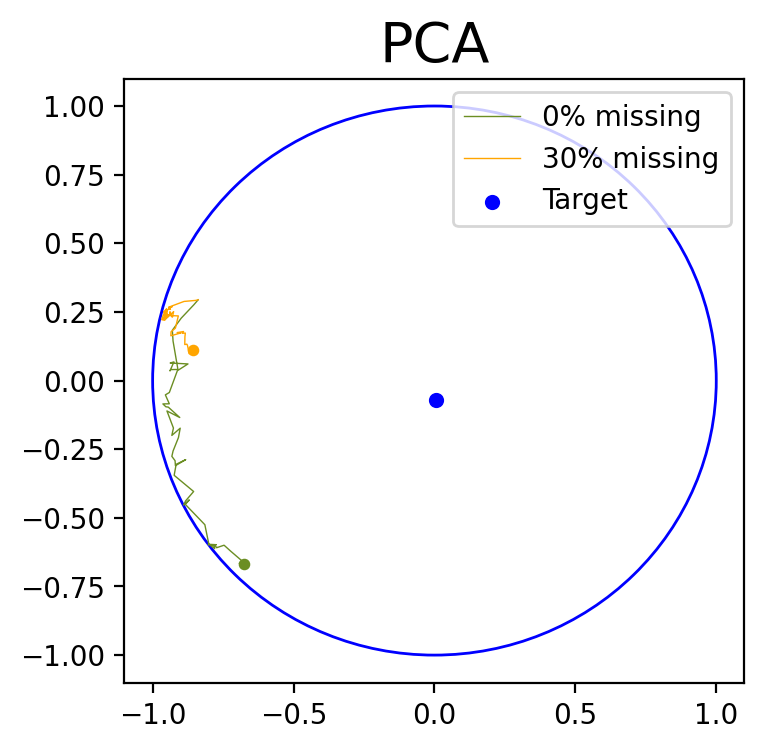

In [58]:
merged_U_array = S[:,0]
for i in range(1,S.shape[1]):
    merged_U_array = np.concatenate( (merged_U_array, S[:,i]), axis = 0 )

if 'Targets' in optional_params:
    merged_U_array = np.concatenate( (optional_params['Targets'], merged_U_array), axis = 0 )


b_array_pca = b_array_init(count = -1, style = 'PCA', U_array = merged_U_array.copy())


new_plot_b_array_path(b_array = b_array_pca,
                            labels = labels,
                            paths_count = S.shape[1],
                            path_length = S.shape[0],
                            targets_count = 1,
                            video = False,
                            title = 'PCA',
                            save = True,
                            plot = True,
                            format = 'pdf',
                            tail = -1,
                            path_names = optional_params['path_names']
                            )

In [52]:

dists = [[],[]]
for time in range(embedding.shape[0]):
    for seq in range(embedding.shape[1]):
        dists[seq].append(d_p(embedding[time, seq], info['Target'][0], method = 'Poincare'))



tSNE_dists = [[],[]]
for time in range(tSNE_embedding.shape[0]):
    for seq in range(tSNE_embedding.shape[1]):
        tSNE_dists[seq].append(d_p(tSNE_embedding[time, seq], info['Target'][0]))

        
targets_count = 1
U_array = S
b_array = np.zeros((U_array.shape[0],U_array.shape[1],2))
for col in range(U_array.shape[1]):
    b_array[:,col] = b_array_pca[targets_count + col * U_array.shape[0] : targets_count + (col+1) * U_array.shape[0]]

target = b_array_pca[:targets_count].copy()

PCA_dists = [[],[]]
for time in range(b_array.shape[0]):
    for seq in range(b_array.shape[1]):
        PCA_dists[seq].append( np.linalg.norm(b_array[time, seq]- target) )
        
        
targets_count = 1
U_array = S
GDS_b_array = np.zeros((U_array.shape[0],U_array.shape[1],2))
for col in range(U_array.shape[1]):
    GDS_b_array[:,col] = b_array_GDM[targets_count + col * U_array.shape[0] : targets_count + (col+1) * U_array.shape[0]]

target = b_array_GDM[:targets_count].copy()

GDS_dists = [[],[]]
for time in range(GDS_b_array.shape[0]):
    for seq in range(GDS_b_array.shape[1]):
        GDS_dists[seq].append( np.linalg.norm(GDS_b_array[time, seq]- target) )


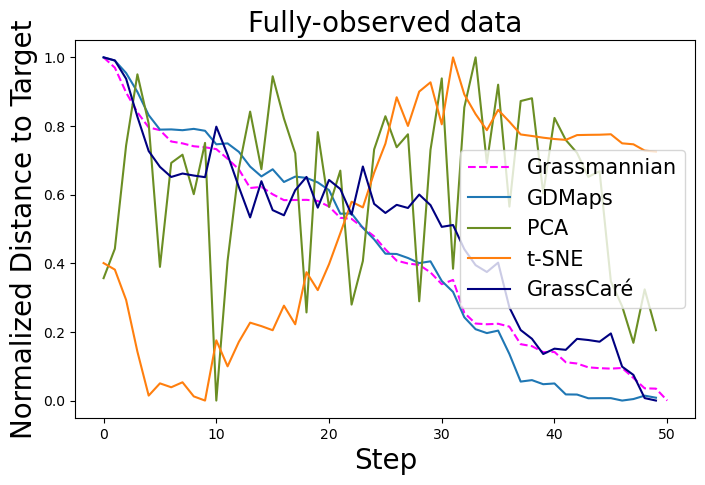

In [62]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
cmap=plt.get_cmap("jet")

plt.figure(dpi = 100, figsize= (8,5))

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


normalized_gd = paths_obj[0] - min(paths_obj[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd, linestyle = 'dashed',c = 'fuchsia', label = 'Grassmannian')

normalized_gd = GDS_dists[0] - min(GDS_dists[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd,label = 'GDMaps')

normalized_gd = PCA_dists[0] - min(PCA_dists[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd, c = 'olivedrab',label = 'PCA')


normalized_gd = tSNE_dists[0] - min(tSNE_dists[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd ,label = 't-SNE')


normalized_gd = dists[0] - min(dists[0])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd, c = cmap(0) ,label = r'GrassCaré')



plt.ylabel('Normalized Distance to Target')
plt.title('Fully-observed data')
plt.legend()
plt.xlabel('Step')

plt.savefig('fulldataGROUSE.pdf', format = 'pdf')
plt.show()

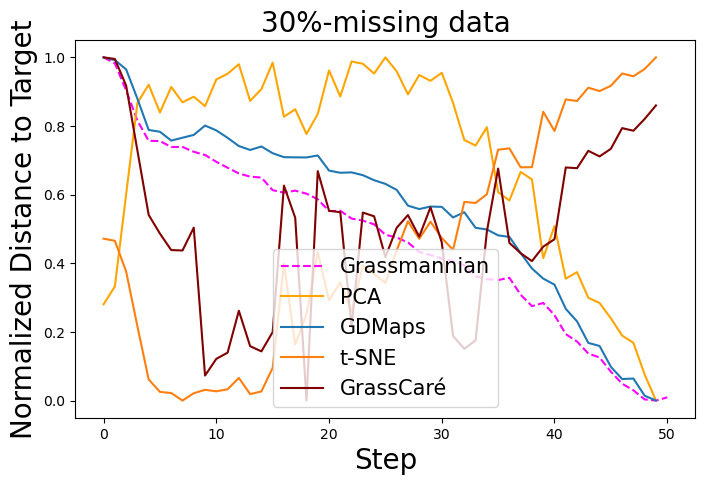

In [61]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
cmap=plt.get_cmap("jet")

plt.figure(dpi = 100, figsize= (8,5))

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


path_index = 1
normalized_gd = paths_obj[path_index] - min(paths_obj[path_index])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd, linestyle = 'dashed',c = 'fuchsia', label = 'Grassmannian')

normalized_gd = PCA_dists[path_index] - min(PCA_dists[path_index])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd, c = 'orange',label = 'PCA')

normalized_gd = GDS_dists[path_index] - min(GDS_dists[path_index])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd,label = 'GDMaps')


normalized_gd = tSNE_dists[path_index] - min(tSNE_dists[path_index])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd ,label = 't-SNE')

normalized_gd = dists[path_index] - min(dists[path_index])
normalized_gd = normalized_gd / max(normalized_gd)
plt.plot(normalized_gd, c = cmap(0.9999) ,label = 'GrassCaré')



plt.title('30%-missing data')

plt.ylabel('Normalized Distance to Target')
plt.legend()
plt.xlabel('Step')

plt.savefig('30missingGROUSE.pdf', format = 'pdf')
plt.show()
